# BESS SoC Estimation from Charge Records

Given a set of charge and discharge metering events for a given battery unit, we want to estimate the rolling state of charge (SoC) and the changes in SoC from one period to the next to properly inform the loss-inclusive SCR-SDR matching.

In [1]:
import math as m

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

Load in data for five BESS plants from September 2024.

In [2]:
bess_data = pd.read_csv("./bess_plant_activity_sep_2024.csv")
bess_data.head()

,Time,MEL,MIL,Expected Output (PN + BOA),PN,"Actual Output (settlement metered, delayed)",SEL,BMU_ID
0,2024-09-01 00:00:00,5.0,-15.0,3.0,3.0,2.42,NaN,T_WISHB-1
1,2024-09-01 00:01:00,3.0,NaN,3.5,NaN,NaN,NaN,T_WISHB-1
2,2024-09-01 00:02:00,4.0,NaN,4.0,4.0,NaN,NaN,T_WISHB-1
3,2024-09-01 00:28:00,4.0,NaN,4.0,4.0,NaN,NaN,T_WISHB-1
4,2024-09-01 00:29:00,3.0,NaN,3.5,NaN,NaN,NaN,T_WISHB-1


Retrieve only the HH metered output with settlement adjustments.

In [3]:
bess_data_output = (bess_data
    .assign(Time=pd.to_datetime(bess_data["Time"]))
    .set_index("Time")
    .groupby(["BMU_ID", pd.Grouper(freq="30min")])["Actual Output (settlement metered, delayed)"]
    .sum()
    .reset_index()
    .pivot(columns="BMU_ID", values="Actual Output (settlement metered, delayed)", index="Time")
)

bess_data_output.head()

BMU_ID,2__BFSEN005,E_DOLLB-1,E_PILLB-2,T_COVNB-1,T_WISHB-1
Time,,,,,
2024-09-01 00:00:00,0.97,34.38,1.78,48.91,2.42
2024-09-01 00:30:00,-0.38,50.83,0.00,5.23,4.75
2024-09-01 01:00:00,0.35,21.41,0.93,-1.45,2.77
2024-09-01 01:30:00,0.13,-0.28,-0.03,-0.91,-0.22
2024-09-01 02:00:00,-1.10,-15.29,-0.56,-0.58,-11.02


<Axes: xlabel='Time'>

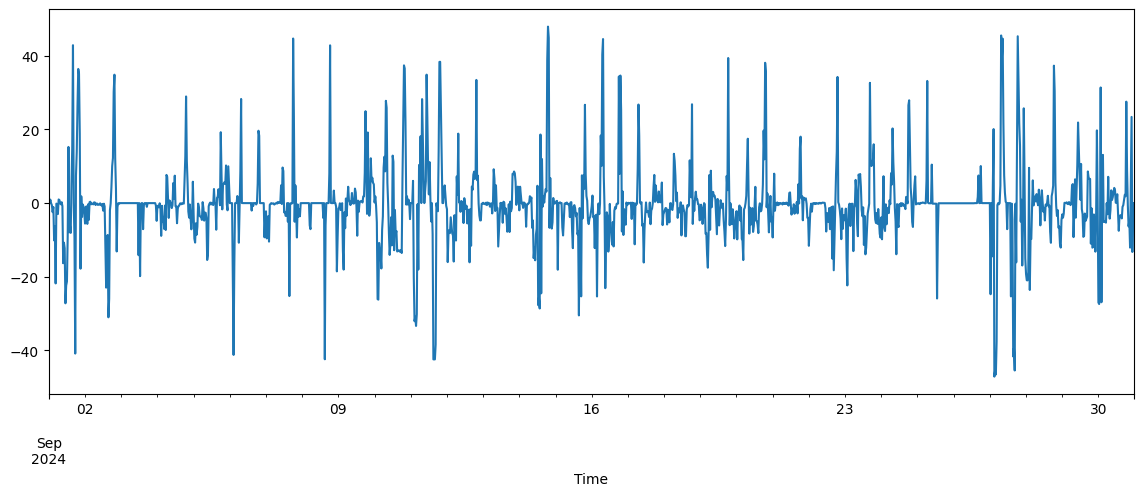

In [4]:
bess_data_output["E_PILLB-2"].plot(figsize = (14, 5))

Plotting the cumulative charge/discharge shows the impact of losses on the units.

<Axes: xlabel='Time'>

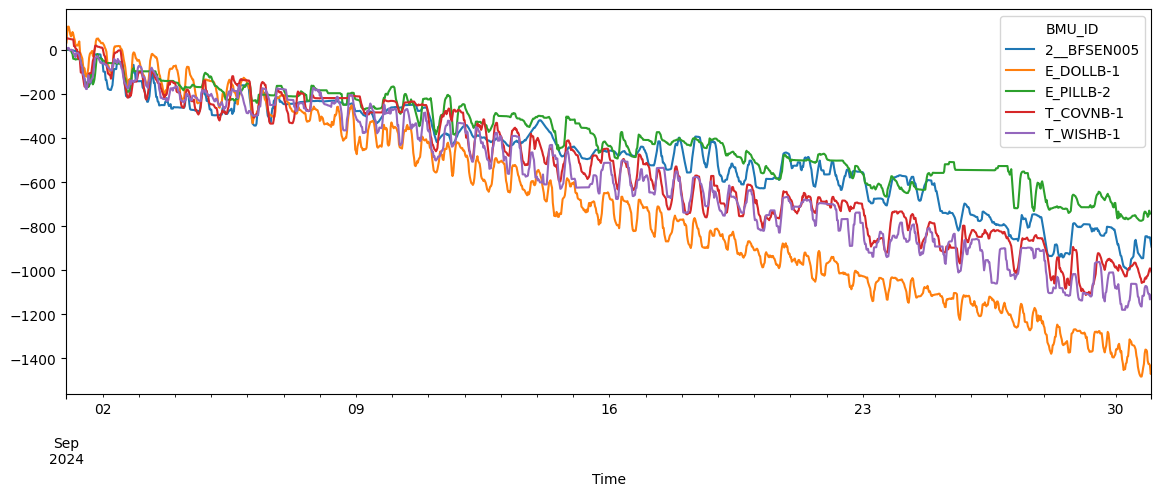

In [5]:
bess_data_output.cumsum().plot(figsize = (14, 5))

Information on plants retrieved from public sources. Round-trip efficiencies estimated by taking total energy out over total energy in over the period.

In [6]:
# MW
bess_ratings = {
    "2__BFSEN005": 50,
    "E_DOLLB-1": 99.9,
    "E_PILLB-2": 49.9,
    "T_COVNB-1": 50,
    "T_WISHB-1": 51,
}

# Hours
bess_durations = {
    "2__BFSEN005": 1,
    "E_DOLLB-1": 1,
    "E_PILLB-2": 2,
    "T_COVNB-1": 2,
    "T_WISHB-1": 2,
}

# %
bess_round_trip_efficiency_estimates = {
    "2__BFSEN005": abs(bess_data_output[bess_data_output["2__BFSEN005"] > 0]["2__BFSEN005"].sum() / bess_data_output[bess_data_output["2__BFSEN005"] < 0]["2__BFSEN005"].sum()),
    "E_DOLLB-1": abs(bess_data_output[bess_data_output["E_DOLLB-1"] > 0]["E_DOLLB-1"].sum() / bess_data_output[bess_data_output["E_DOLLB-1"] < 0]["E_DOLLB-1"].sum()),
    "E_PILLB-2": abs(bess_data_output[bess_data_output["E_PILLB-2"] > 0]["E_PILLB-2"].sum() / bess_data_output[bess_data_output["E_PILLB-2"] < 0]["E_PILLB-2"].sum()),
    "T_COVNB-1": abs(bess_data_output[bess_data_output["T_COVNB-1"] > 0]["T_COVNB-1"].sum() / bess_data_output[bess_data_output["T_COVNB-1"] < 0]["T_COVNB-1"].sum()),
    "T_WISHB-1": abs(bess_data_output[bess_data_output["T_WISHB-1"] > 0]["T_WISHB-1"].sum() / bess_data_output[bess_data_output["T_WISHB-1"] < 0]["T_WISHB-1"].sum()),
}

The function below applies the charge and discharge losses (assuming they are equal for simplicity, and without parasitic losses) to estimate the change in SoC from one HH to the next. The starting SoC is arbitrary as we do not know at the beginning of the period what the SoC is, but we can infer to some extent based on the bounds of the SoC profile as a whole (i.e. they should remain between 0 and 1 for the duration of the measurement period).

However, as can be seen below, there are clearly factors we are missing, as the SoC routinely exceeds the bounds even with adjustments to the round trip efficiencies. But as as first order approximation, it is good enough.

Text(0.5, 0, '')

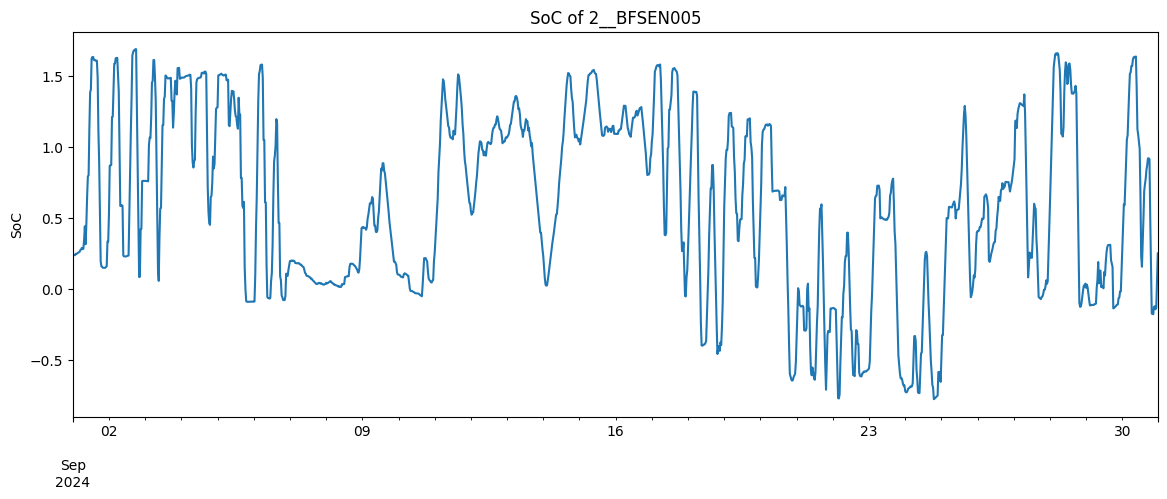

In [7]:
bmu_id = "2__BFSEN005"

start_soc = 0.25
freq = 30 # minutes
capacity_MWh = bess_ratings[bmu_id] * bess_durations[bmu_id]
round_trip_efficiency = bess_round_trip_efficiency_estimates[bmu_id]

def soc_delta(power: float, round_trip_efficiency: float, freq: int, bess_capacity: float) -> float:
    return (freq / 60) * power * (m.sqrt(round_trip_efficiency) if power < 0 else 1 / m.sqrt(round_trip_efficiency)) / bess_capacity

def calculate_soc(bess_data_output: pd.DataFrame, bmu_id: str, bess_capacity: float, start_soc: float, round_trip_efficiency: float, freq: int) -> pd.DataFrame:

    # init soc column for first BESS
    # soc column indicates soc at end of period, given charge/discharge for that period
    bess_output_one_bess = bess_data_output[[bmu_id]].copy()
    bess_output_one_bess["soc"] = None

    # calculate soc for each row
    for idx_time, row in bess_output_one_bess.iterrows():
        
        if idx_time == bess_output_one_bess.index[0]:
            prev_soc = start_soc
        else:
            prev_soc = bess_output_one_bess.loc[bess_output_one_bess.index[bess_output_one_bess.index.get_loc(idx_time) - 1], "soc"]
        curr_power = row[bmu_id]
        
        # calculate soc with charging defined as negative power
        curr_soc = prev_soc - soc_delta(curr_power, round_trip_efficiency, freq, bess_capacity) 
        bess_output_one_bess.loc[idx_time, "soc"] = curr_soc

    return bess_output_one_bess

bess_output_one_bess = calculate_soc(bess_data_output, bmu_id, capacity_MWh, start_soc, round_trip_efficiency, freq)

fig = bess_output_one_bess.soc.plot(figsize = (14, 5), title = f"SoC of {bmu_id}")
fig.set_ylabel("SoC")
fig.set_xlabel("")

In [8]:
bess_output_one_bess.head()

BMU_ID,2__BFSEN005,soc
Time,,
2024-09-01 00:00:00,0.97,0.239367
2024-09-01 00:30:00,-0.38,0.242834
2024-09-01 01:00:00,0.35,0.238998
2024-09-01 01:30:00,0.13,0.237573
2024-09-01 02:00:00,-1.10,0.247608


In [ ]:
bess_output_one_bess.to_csv(f"bess_soc_{bmu_id}.csv")